# [7.2 Networks Using Blocks (VGG)](https://d2l.ai/chapter_convolutional-modern/vgg.html)

Paper : [Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan & Zisserman 2015)](https://arxiv.org/abs/1409.1556)

### Recall : Convolution Layers

#### **n x n** image + padding p, convolve with a k x k kernel, stride s → Output dimension = (n+2p-k)/s + 1


### The basic building block of classic CNNs is a sequence of the following:

(i) a convolutional layer with padding to maintain the resolution

(ii) a nonlinearity such as a ReLU

(iii) a pooling layer such as a maximum pooling layer

### VGG block

- One VGG block consists of a sequence of convolutional layers, followed by a maximum pooling layer for spatial downsampling.

- All Conv layers in VGG are **3x3**, with **padding=1** -> to keep the spatial dimension the same after convolution.

- All Pooling layers in VGG are **2x2 maximum pooling**, with **stride of 2**. -> to make the spatial dimension be 1/2 of the input dimension 

### VGG Network

<img src='./images/fig_7.2.1.png' width='600'/>

#### A general guideline of ConvNet architectur from Simonyan & Zisserman 2015: 


- Better performace if using **smaller receptive window size** and **smaller stride** of the first convolutional layer. <br>
  c.f. AlexNet's 1st ConV layer has kernel 11x11, stride=4.
  
  
- The increased depth led to better performance. <br> VGG increases the receptive field by stacking more ConV layers with smaller kernel size. <br>
    - A stack of 2 3x3 ConV layers (without pooling) has an effective field of 5x5.
    - A stack of 3 3x3 ConV layers (without pooling) has an effective field of 7x7.
    - Given a fixed receptive field, a stack of smaller ConV layers has less parameters compared with a single ConV layer with larger kernel size. 

#### Implementation details of VGG back in 2015:

- "On a system equipped with four NVIDIA Titan Black GPUs, training a single net took 2–3 weeks depending on the architecture."

## Implement VGG-11 in PyTorch

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [3]:
class VGG11(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        
        # Conv blocks (3x3 ConV + ReLU activation ... + maxPool)
        self.block1 = vgg_block(1,   1,  64)
        self.block2 = vgg_block(1,  64, 128)
        self.block3 = vgg_block(2, 128, 256)
        self.block4 = vgg_block(2, 256, 512)
        self.block5 = vgg_block(2, 512, 512)
        
        # FC layers part
        
        self.fc1 = nn.Sequential(nn.Linear(512 * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5))
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5))
        self.fc3 = nn.Linear(4096, n_classes)
        
    def forward(self, x):
        
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        
        out = out.view(out.size(0), -1) # flatten the features 
        
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [4]:
net = VGG11(n_classes = 10)
net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))


Total network parameters : 128806154


- VGG-11 has ~ 130M trainable parameters. Most of the parameters are from the last three fully-connected layers.

In [5]:
net

VGG11(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [6]:
# check the dimension of the network
X = torch.randn(size=(1, 1, 224, 224)).to(device)
out = net(X)
out.shape

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 10])

In [7]:
### Load FashionMNIST dataset and apply data transform, make input dimension 28x28 -> 224x224

transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

batch_size = 32

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))
images.shape

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([32, 1, 224, 224])

In [8]:
### Loss function
criterion = nn.CrossEntropyLoss()

In [9]:
### Optimizer
learning_rate = 0.05

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [10]:
### Training function

def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [11]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

num_epochs = 10
for epoch in range(0, num_epochs):
    since = time.time()
    
    train_1_epoch(net, optimizer, train_loss, train_acc)
    validation(net, valid_loss, valid_acc)
    
    time_elapsed = time.time() - since
    print(f'\tTime: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

>>> End epoch 1, train accuracy = 27.64%, train avgLoss = 1.8651
>>>              valid accuracy = 80.87%, valid avgLoss = 0.5117
	Time: 4m 45s
>>> End epoch 2, train accuracy = 84.64%, train avgLoss = 0.4141
>>>              valid accuracy = 85.25%, valid avgLoss = 0.4050
	Time: 4m 46s
>>> End epoch 3, train accuracy = 88.75%, train avgLoss = 0.3026
>>>              valid accuracy = 89.28%, valid avgLoss = 0.2922
	Time: 4m 46s
>>> End epoch 4, train accuracy = 90.49%, train avgLoss = 0.2565
>>>              valid accuracy = 90.94%, valid avgLoss = 0.2491
	Time: 4m 46s
>>> End epoch 5, train accuracy = 91.67%, train avgLoss = 0.2273
>>>              valid accuracy = 90.66%, valid avgLoss = 0.2508
	Time: 4m 46s
>>> End epoch 6, train accuracy = 92.52%, train avgLoss = 0.2035
>>>              valid accuracy = 91.93%, valid avgLoss = 0.2328
	Time: 4m 46s
>>> End epoch 7, train accuracy = 93.28%, train avgLoss = 0.1840
>>>              valid accuracy = 92.57%, valid avgLoss = 0.2060
	Time:

### Plot

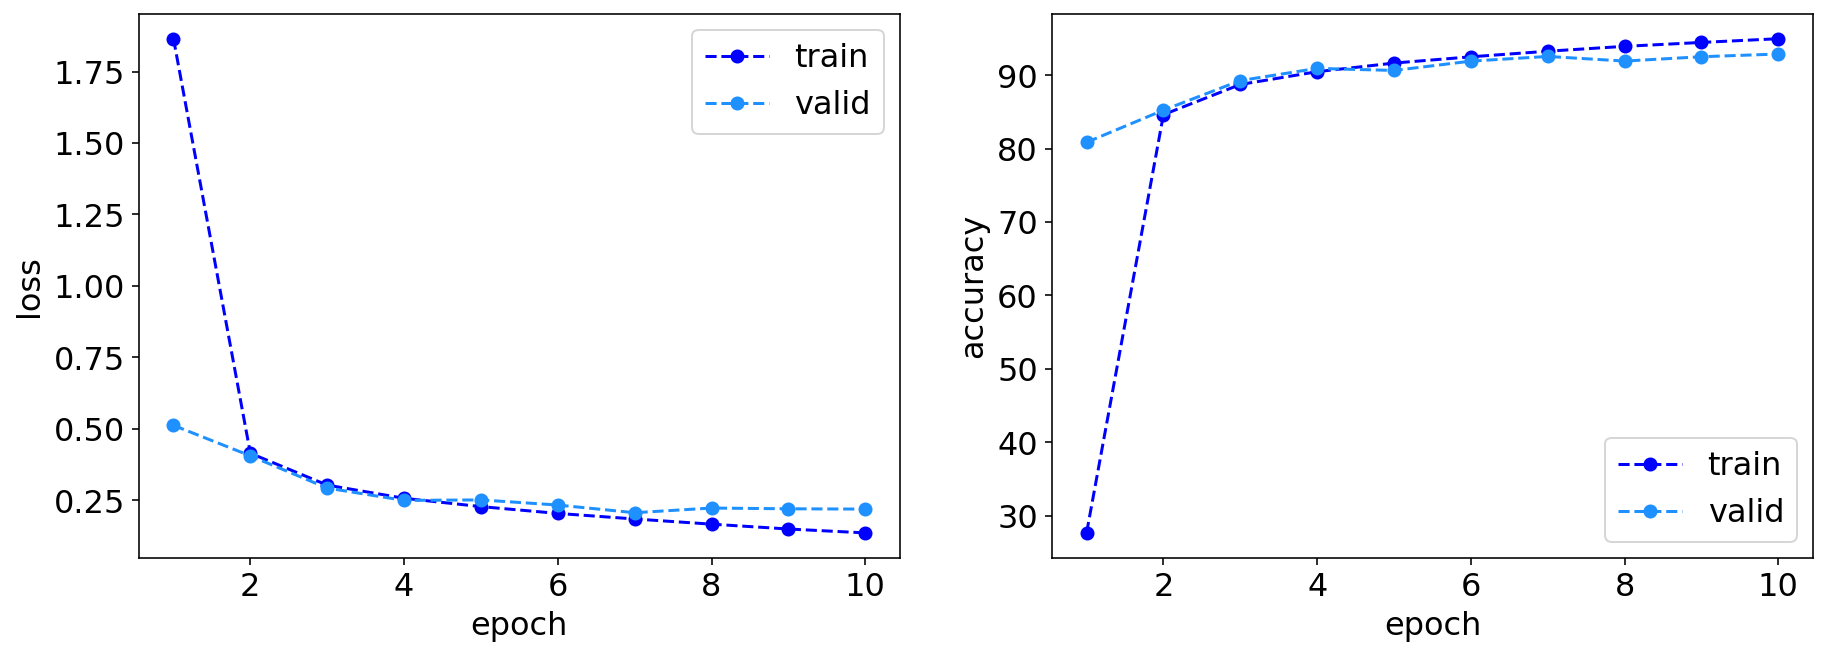

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')